# Notebook 05 - Randomization Test (Null Model) for Momentum Swings

目标：检验“势头转折点 swing”是否可能只是随机得分序列的产物。

思路（Null Model 1）：
- 保留真实比赛的发球顺序（server 序列不变）
- 假设每一分的胜负仅由发球优势决定：
  - 发球方以概率 p_server_win 赢得该分
- 重复模拟 n_sim 次“随机比赛”
- 对每次模拟：
  - 计算 momentum（serve-adjusted EWMA）
  - 用同一套 swing 检测参数计算 swing_count
- 将真实比赛的 swing_count 与随机分布对比，计算 p-value/分位数

输出：
1) 随机 swing_count 分布图 + 真实值竖线
2) p-value 或 percentile（真实值在随机分布中的位置）
3) 导出：随机结果 CSV + 图 PNG 到 reports/


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data.match import (
    load_raw_points_csv,
    get_match,
    add_point_result,
    add_serve_adjusted_contrib,
)
from src.features.momentum import compute_momentum
from src.features.swings import detect_swings, SwingParams
from src.viz.plots import plot_momentum_with_swings


In [2]:
# =========================
# 参数面板（只改这一单元格）
# =========================

MATCH_ID = "2023-wimbledon-1701"
DATA_PATH = "../data/raw/Wimbledon_featured_matches.csv"

# 输出目录（默认不提交 git；你已设置 .gitignore）
FIG_DIR = Path("../reports/figures")
TAB_DIR = Path("../reports/tables")

# 真实势头参数（与前面一致）
MOM_SPAN = 25

# swing 检测参数（固定，用于真实与随机一致对比）
SWING_PARAMS = SwingParams(
    trend_span=5,
    amp_q=0.85,
    cool=15
)

# 随机模拟次数（建议：先 200 快速跑通；最终 1000~3000）
N_SIM = 500

# 随机种子（保证可复现）
SEED = 42

# 是否保存真实比赛的势头+swing图（方便论文引用）
SAVE_REAL_FIG = True


## 数据准备：真实比赛

- 抽取并排序单场比赛
- 构造 serve-adjusted 贡献（估计 p_server_win）
- 计算真实比赛的势头曲线与 swing_count（作为对照基准）


In [3]:
df = load_raw_points_csv(DATA_PATH)

df_match = get_match(df, MATCH_ID)
df_match = add_point_result(df_match)
df_match, p_server = add_serve_adjusted_contrib(df_match)  # 估计发球胜率 p_server

# 真实势头（serve-adjusted EWMA）
m_real = compute_momentum(df_match, method="srv_ewm", span=MOM_SPAN)

# 真实 swing
swing_flag_real, swing_pos_real, amp_thr_real = detect_swings(m_real, params=SWING_PARAMS)

real_swing_count = int(swing_flag_real.sum())

print("MATCH_ID:", MATCH_ID)
print("rows:", df_match.shape[0])
print("p_server:", round(p_server, 4))
print("amp_thr_real:", round(amp_thr_real, 4))
print("real_swing_count:", real_swing_count)


MATCH_ID: 2023-wimbledon-1701
rows: 334
p_server: 0.6108
amp_thr_real: 0.1737
real_swing_count: 3


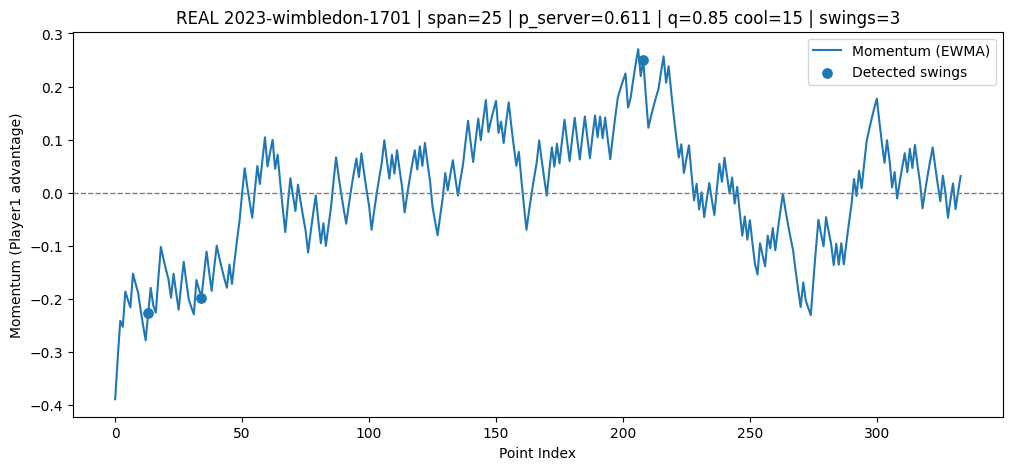

In [4]:
FIG_DIR.mkdir(parents=True, exist_ok=True)

if SAVE_REAL_FIG:
    out_path = FIG_DIR / f"{MATCH_ID}_REAL_span{MOM_SPAN}_q{SWING_PARAMS.amp_q}_cool{SWING_PARAMS.cool}.png"
    title = (
        f"REAL {MATCH_ID} | span={MOM_SPAN} | p_server={p_server:.3f} "
        f"| q={SWING_PARAMS.amp_q} cool={SWING_PARAMS.cool} | swings={real_swing_count}"
    )
    plot_momentum_with_swings(m_real, swing_flag=swing_flag_real, title=title, out_path=out_path)
    out_path


## Null Model 1：保留发球顺序的随机胜负

我们生成 n_sim 条“随机比赛”，每条随机比赛满足：
- server 序列与真实比赛完全相同
- 每一分发球方以概率 p_server_win 赢得该分
- 由此得到 point_victor_random
- 进一步构造 serve_adj_p1_random → momentum_random → swing_count_random

关键点：
- 真实与随机都用同一套 momentum 参数与 swing 参数
- 对比统计量：swing_count（也可扩展到 swing 强度等）


In [5]:
def simulate_one_null_match(server: np.ndarray, p_server: float, rng: np.random.Generator) -> np.ndarray:
    """
    给定 server 序列（1/2），按 p_server 随机生成赢家（1/2）。

    规则：
    - 以概率 p_server：赢家 = server
    - 否则：赢家 = 3 - server（另一方）

    Returns
    -------
    winner : np.ndarray
        与 server 同长度，取值 1/2
    """
    u = rng.random(len(server))
    winner = np.where(u < p_server, server, 3 - server)
    return winner


def build_serve_adj_p1_from_server_and_winner(server: np.ndarray, winner: np.ndarray, p_server: float) -> np.ndarray:
    """
    从 server 和 winner 生成 serve_adj_p1（Player1 视角的发球校正贡献）。

    发球方视角：
    - 发球方赢： + (1 - p_server)
    - 接发方赢： - p_server

    Player1 视角：
    - 若 server==1：同向
    - 若 server==2：取反
    """
    serve_wins = (winner == server).astype(int)
    serve_adj = np.where(serve_wins == 1, 1 - p_server, -p_server)
    serve_adj_p1 = np.where(server == 1, serve_adj, -serve_adj)
    return serve_adj_p1


In [6]:
rng = np.random.default_rng(SEED)

server_seq = df_match["server"].to_numpy()
n = len(server_seq)

swing_counts = []
amp_thrs = []

# 可选：也记录更多统计量（扩展用）
mean_abs_m = []
max_abs_m = []

for _ in range(N_SIM):
    winner_sim = simulate_one_null_match(server_seq, p_server, rng)
    serve_adj_p1_sim = build_serve_adj_p1_from_server_and_winner(server_seq, winner_sim, p_server)

    # 计算随机势头（与真实一致：srv_ewm, span=MOM_SPAN）
    m_sim = pd.Series(serve_adj_p1_sim).ewm(span=MOM_SPAN, adjust=False).mean()

    # swing 检测（与真实一致）
    swing_flag_sim, swing_pos_sim, amp_thr_sim = detect_swings(m_sim, params=SWING_PARAMS)

    swing_counts.append(int(swing_flag_sim.sum()))
    amp_thrs.append(float(amp_thr_sim))
    mean_abs_m.append(float(m_sim.abs().mean()))
    max_abs_m.append(float(m_sim.abs().max()))

swing_counts = np.array(swing_counts)
amp_thrs = np.array(amp_thrs)

print("simulations:", N_SIM)
print("swing_count_sim mean:", swing_counts.mean(), "std:", swing_counts.std())
print("amp_thr_sim mean:", amp_thrs.mean(), "std:", amp_thrs.std())


simulations: 500
swing_count_sim mean: 3.5 std: 0.9705668446840743
amp_thr_sim mean: 0.15428607547067752 std: 0.020865427678491266


## 显著性度量（p-value / percentile）

两种常用方式：

- Percentile：真实值在随机分布中的百分位位置（越极端越显著）
- p-value：在零假设下得到“至少和真实一样极端”的概率

这里我们以 swing_count 为例，给出：
- 右尾检验：P(sim >= real)
- 双尾检验：按 |x - mean| 的极端程度（可选）

建模赛中通常用“右尾”或“百分位”已经足够直观。


In [8]:
# Percentile（真实值在随机分布中的百分位）
percentile = (swing_counts <= real_swing_count).mean() * 100

# 右尾 p-value：随机 >= 真实 的概率（真实 swing_count 如果明显更大，则 p 很小）
p_right = (swing_counts >= real_swing_count).mean()

print("REAL swing_count:", real_swing_count)
print("Random mean±std:", round(swing_counts.mean(), 2), "±", round(swing_counts.std(), 2))
print("Percentile of real in null distribution:", round(percentile, 2), "%")
print("Right-tail p-value P(sim >= real):", round(p_right, 4))


REAL swing_count: 3
Random mean±std: 3.5 ± 0.97
Percentile of real in null distribution: 49.8 %
Right-tail p-value P(sim >= real): 0.856


## 可视化：随机分布 + 真实值

我们画出 swing_count 的直方图，并用竖线标出真实比赛的 swing_count。
图与 p-value 一起组成论文中最核心的“随机论检验”证据。


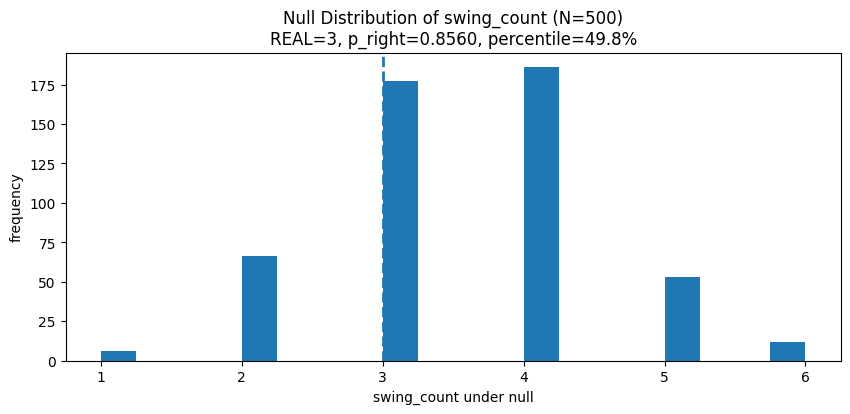

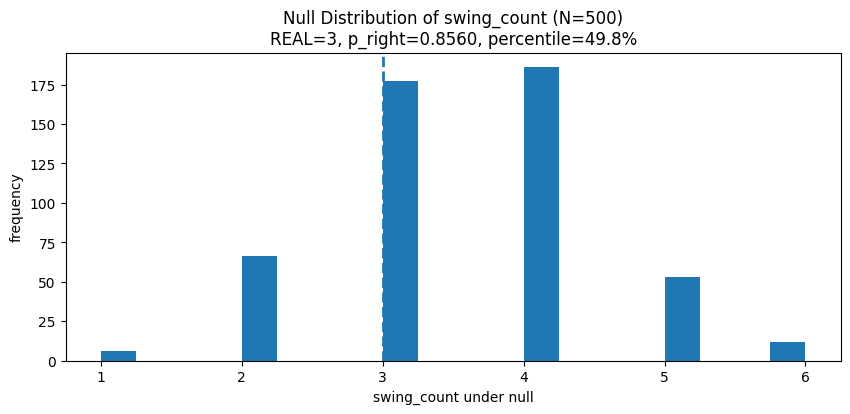

WindowsPath('../reports/figures/2023-wimbledon-1701_NULL_swingcount_hist_N500.png')

In [9]:
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(10, 4))
plt.hist(swing_counts, bins=20)
plt.axvline(real_swing_count, linewidth=2, linestyle="--")
plt.title(
    f"Null Distribution of swing_count (N={N_SIM})\n"
    f"REAL={real_swing_count}, p_right={p_right:.4f}, percentile={percentile:.1f}%"
)
plt.xlabel("swing_count under null")
plt.ylabel("frequency")
plt.show()

fig_path = FIG_DIR / f"{MATCH_ID}_NULL_swingcount_hist_N{N_SIM}.png"
plt.figure(figsize=(10, 4))
plt.hist(swing_counts, bins=20)
plt.axvline(real_swing_count, linewidth=2, linestyle="--")
plt.title(
    f"Null Distribution of swing_count (N={N_SIM})\n"
    f"REAL={real_swing_count}, p_right={p_right:.4f}, percentile={percentile:.1f}%"
)
plt.xlabel("swing_count under null")
plt.ylabel("frequency")
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, bbox_inches="tight", dpi=200)
plt.show()

fig_path


## 导出随机结果表（CSV）

导出包含每次模拟的：
- swing_count
- amp_thr（自适应阈值）
- mean_abs_m / max_abs_m（辅助统计）

队友写论文时可以直接引用这些表，做补充图或附录。


In [10]:
TAB_DIR.mkdir(parents=True, exist_ok=True)

df_null = pd.DataFrame({
    "swing_count": swing_counts,
    "amp_thr": amp_thrs,
    "mean_abs_m": mean_abs_m,
    "max_abs_m": max_abs_m,
})

csv_path = TAB_DIR / f"{MATCH_ID}_NULL_results_N{N_SIM}.csv"
df_null.to_csv(csv_path, index=False)

summary = {
    "match_id": MATCH_ID,
    "N_SIM": N_SIM,
    "seed": SEED,
    "p_server": p_server,
    "mom_span": MOM_SPAN,
    "trend_span": SWING_PARAMS.trend_span,
    "amp_q": SWING_PARAMS.amp_q,
    "cool": SWING_PARAMS.cool,
    "real_swing_count": real_swing_count,
    "null_mean": float(swing_counts.mean()),
    "null_std": float(swing_counts.std()),
    "percentile": float(percentile),
    "p_right": float(p_right),
}
df_summary = pd.DataFrame([summary])

csv_summary = TAB_DIR / f"{MATCH_ID}_NULL_summary_N{N_SIM}.csv"
df_summary.to_csv(csv_summary, index=False)

csv_path, csv_summary, df_summary


(WindowsPath('../reports/tables/2023-wimbledon-1701_NULL_results_N500.csv'),
 WindowsPath('../reports/tables/2023-wimbledon-1701_NULL_summary_N500.csv'),
               match_id  N_SIM  seed  p_server  mom_span  trend_span  amp_q  \
 0  2023-wimbledon-1701    500    42  0.610778        25           5   0.85   
 
    cool  real_swing_count  null_mean  null_std  percentile  p_right  
 0    15                 3        3.5  0.970567        49.8    0.856  )

## 论文/报告可用结论

在零假设（保留发球顺序且每分仅由发球胜率决定的随机模型）下，
我们模拟得到 swing_count 的分布。真实比赛的 swing_count 为 REAL，
位于随机分布的第 P 百分位，右尾检验 p-value 为 p。

若 p 很小（例如 < 0.05），则表明真实比赛中势头转折事件的数量显著偏离随机模型，
支持“势头转折并非完全由随机波动造成”的观点。

若 p 不小，则说明仅以 swing_count 为统计量时难以拒绝随机假设，
需要进一步采用更敏感的统计量（如 swing 强度、持续时间、与破发事件的关联等）进行检验。
